In [1]:
# todo
# 아래처럼 샵으로 감싸진 블록들은 제거될 예정입니다.

################################################################################
# 제거될 블럭
################################################################################

# **YAI 8th term: Team Project**
****RSNA pneumonia X-ray Image Data + COVID-19 X-ray Image Data Detection****

**Participants**
* Dongha Kim - Yonsei Univ. College of Medicine.
* Jeongeun Lee - Yonsei Univ. Dept. of Computer Science.
* Junho Lee - Yonsei Univ. Dept. of Computer & Telecommunications Engineering.
* Suyeong Choi - Yonsei Univ. Dept. of Psychology

**Full Source Code**
* https://github.com/kdha0727/lung-opacity-and-covid-chest-x-ray-detection

All non-necessary codes are modularized as package. Watch all codes in github repository.

## Description
X-ray photographs of representative lung diseases, Lung Opacity and COVID-19, will be classified as
deep learning, and patient disease will be classified with minimal Cost by detecting each disease site.
Correlation analysis of diseases according to gender age and correlation analysis and visualization
using various worldwide COVID-19 statistical indicators will be carried out.

## Datasets
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview
* https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

## Model Architecture

**EfficientNet**
* https://arxiv.org/abs/1905.11946

**Implementation (as tensorflow)**
* https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet

# Preparations

## Data Mounting

In [2]:
################################################################################
# Project Boundary 내에서는 ImportError 가 발생하지 않습니다.
# 따라서 프로젝트 모듈 중 하나인 library_check 모듈을 import 성공하는지 여부로
# Colaboratory 런타임인지 여부를 확인합니다.
################################################################################

# Check, with local module, whether runtime is colaboratory

try:  # local runtime
    import library_check
except ImportError:  # colab runtime
    library_check = None
    from google.colab import drive  # NOQA
    drive.mount('/content/drive')  # NOQA
    colaboratory = True
else:
    colaboratory = False

## Runtime Check

In [3]:
# System Information

import sys
import platform
print(f"OS version: \t\t{platform.platform()}\n"
      f"Python version:\t\t{sys.version}")

OS version: 		macOS-11.5.2-arm64-arm-64bit
Python version:		3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:27:18) 
[Clang 11.1.0 ]


In [4]:
# GPU Information

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0 or gpu_info.find('not found') >= 0:
    if colaboratory:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
else:
    print(gpu_info)

In [5]:
# Memory Information

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if colaboratory:
    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type" '
              'menu, and then select High-RAM in the Runtime shape dropdown. Then, '
              're-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

Your runtime has 17.2 gigabytes of available RAM



## Library Installation

In [6]:
################################################################################
# Colaboratory Runtime 의 경우, 요구되는 라이브러리들을 전부 설치한 뒤
# 사용되는 Python Script 들을 git 에서 clone 하고 import 하여 라이브러리를 확인합니다.
# 그 후, 데이터셋 wrapper 스크립트에 데이터들이 저장된 경로를 등록합니다.
################################################################################

# Install required libraries

if colaboratory:  # colab runtime
    !pip install pydicom
    # !pip install mxnet-cu101==1.7.0 d2l==0.16.6
    !git clone https://github.com/kdha0727/lung-opacity-and-covid-chest-x-ray-detection/
    %cd lung-opacity-and-covid-chest-x-ray-detection
    import library_check
    library_check.check()
    import data_prep_utils
    root = "/content/drive/Shareddrives/2021 하계 SAT/"
    data_prep_utils.set_root(root)
else:  # local runtime
    library_check.check()
    import data_prep_utils
data_prep_utils.init()

All required libraries are installed.


In [7]:
# After all installation, import all libraries used.

import inspect
import random
import pydicom as dcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F  # NOQA
import torch.optim as optim
import torch.utils.data
import torch
import torchvision
import torchsummary

from skimage import io, transform

In [ ]:
# And, import custom-defined Lazy Data Wrappers and Utilities

from data_prep_utils import covid_19_radiography_dataset
from data_prep_utils import rsna_pneumonia_detection_challenge

from data_prep_utils.dataset import pil_loader, dicom_loader
import train_utils

################################################################################
# Dataset Wrapper 를 사용하여 파일들에 편하게 접근할 수 있습니다.
################################################################################

################################################################################
# Data Wrapper 소스 보기
print(inspect.getsource(rsna_pneumonia_detection_challenge.__class__))
print(inspect.getsource(covid_19_radiography_dataset.__class__))
################################################################################

# Data Analysis and Processing

* Note: All preprocessing processes are modularized as "Data Wrapper" package

**Class Information**
* Normal: 0

# Data Analysis and Processing
* Lung Opacity: 1
* COVID-19: 2
* Viral Pneumonia: 3

In [9]:
print('\n\t'.join(map(str, ['Labels: [', *covid_19_radiography_dataset.class_to_idx.items()])), '\n]')

Labels: [
	('Normal', 0)
	('Lung_Opacity', 1)
	('COVID', 2)
	('Viral Pneumonia', 3) 
]


## **First Dataset: COVID-19 Radiography Dataset**

**Raw CSV Files**

In [10]:
df_metadata = covid_19_radiography_dataset.metadata_csv
df_metadata

,file_name,file_format,image_shape,label,Target
0,COVID-1.png,PNG,"(299, 299)",COVID,2
1,COVID-10.png,PNG,"(299, 299)",COVID,2
2,COVID-100.png,PNG,"(299, 299)",COVID,2
3,COVID-1000.png,PNG,"(299, 299)",COVID,2
4,COVID-1001.png,PNG,"(299, 299)",COVID,2
...,...,...,...,...,...
21160,Viral Pneumonia-995.png,PNG,"(299, 299)",Viral Pneumonia,3
21161,Viral Pneumonia-996.png,PNG,"(299, 299)",Viral Pneumonia,3
21162,Viral Pneumonia-997.png,PNG,"(299, 299)",Viral Pneumonia,3
21163,Viral Pneumonia-998.png,PNG,"(299, 299)",Viral Pneumonia,3


**Target Distribution**

<AxesSubplot:xlabel='label', ylabel='count'>

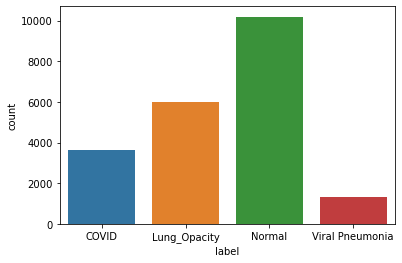

In [11]:
sns.countplot(x=df_metadata["label"])

## **Second Dataset: RSNA Pneumonia Detection Challenge**

**Raw CSV Files**

In [12]:
df_train_labels = rsna_pneumonia_detection_challenge.train_labels_csv
df_train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [13]:
df_class_info = rsna_pneumonia_detection_challenge.class_info_csv
df_class_info

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


**Concatenated and Deduplicated CSV**

In [14]:
df_full = rsna_pneumonia_detection_challenge.full_csv
df_full

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1


**Target Distribution**
* 0 is normal, 1 is Lung Opacity.

<AxesSubplot:xlabel='Target', ylabel='count'>

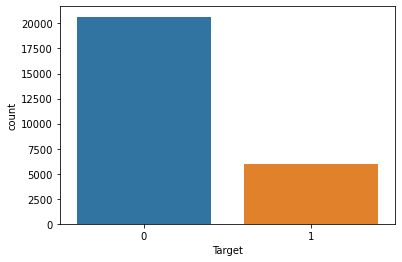

In [15]:
sns.countplot(x=df_train_labels[["patientId", "Target"]].drop_duplicates()['Target'])

**Detailed class Distribution**
* Note: "No Lung Opacity / Not Normal" class is regarded as Normal(0).

<AxesSubplot:xlabel='class', ylabel='count'>

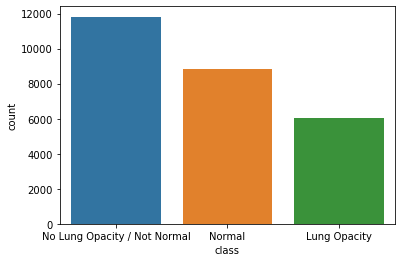

In [16]:
sns.countplot(x=df_class_info[["patientId", "class"]].drop_duplicates()['class'])

**Bounding Box Distribution**

In [17]:
################################################################################
# Lung Opacity 만 있는 DataFrame 에서 Bounding Box 가져오고, 분포를 시각화합니다.
################################################################################
df_lung_opacity = rsna_pneumonia_detection_challenge.lung_opacity_csv
df_lung_opacity

,patientId,class,x,y,width,height,Target
0,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
1,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
2,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,323.0,577.0,160.0,104.0,1
3,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,695.0,575.0,162.0,137.0,1
4,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...,...
9550,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,316.0,504.0,179.0,273.0,1
9551,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,609.0,464.0,240.0,284.0,1
9552,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1
9553,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1


<AxesSubplot:xlabel='x', ylabel='count'>

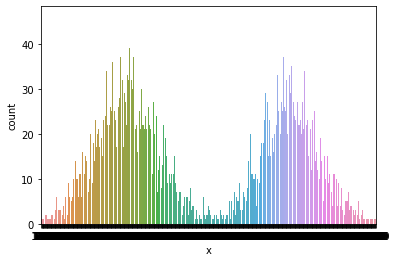

In [18]:
sns.countplot(x=df_lung_opacity['x'])

<AxesSubplot:xlabel='y', ylabel='count'>

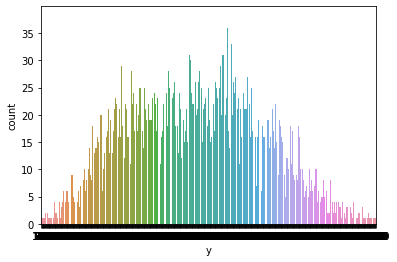

In [19]:
sns.countplot(x=df_lung_opacity['y'])

**Dicom File: Metadata and Image**

In [20]:
rd_path = rsna_pneumonia_detection_challenge.get_random_patient_id()
rd_path = rsna_pneumonia_detection_challenge.get_patient_path(rd_path)

In [21]:
metadata = dcm.dcmread(rd_path)
metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.22137.1517874439.34351
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22137.1517874439.34351
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

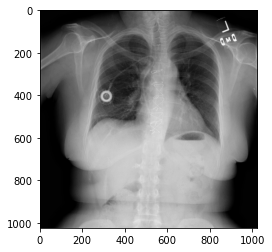

In [22]:
plt.imshow(metadata.pixel_array, cmap=plt.cm.gray)  # NOQA
plt.show()

**Bounding Box**

In [23]:
getPatientPath = rsna_pneumonia_detection_challenge.get_patient_path


def bbox_to_rect(bbox, color):  # bbox = (x1,y1,x2,y2) = (x,y,w+x,h+y)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
        fill=False, edgecolor=color, linewidth=1
    )


def box_image(patient_id):
    fig = plt.imshow(dcm.dcmread(getPatientPath(patient_id)).pixel_array, cmap=plt.cm.gray)  # NOQA
    df = df_lung_opacity[df_lung_opacity['patientId'] == patient_id]
    for _, (x, y, w, h) in df[['x', 'y', 'width', 'height']].iterrows():
        fig.axes.add_patch(bbox_to_rect([x, y, x+w, y+h], 'b'))
    plt.show()

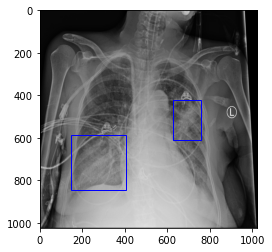

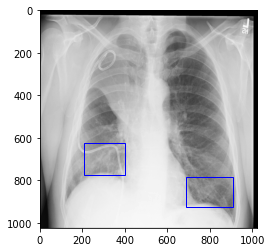

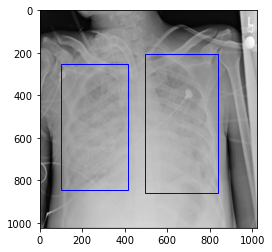

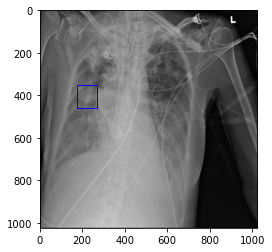

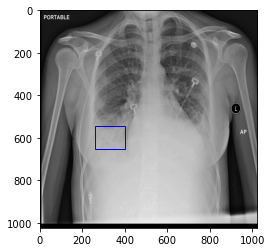

{None}

In [24]:
{*map(box_image, random.choices([*{*df_lung_opacity['patientId']}], k=5))}  # 한줄코딩

**Number of Bounding Box per Patients**

In [25]:
df_n_box = df_lung_opacity.groupby('patientId').size().reset_index(name='boxes')
df_n_box.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


In [ ]:
sns.countplot(x=df_n_box['boxes'])

**Bounding Box Distribution**

<AxesSubplot:xlabel='x', ylabel='y'>

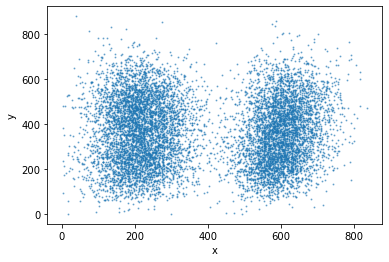

In [27]:
df_lung_opacity.plot.scatter(x='x', y='y', alpha=0.5, s=1)

# Modeling via PyTorch

In [28]:
plt.ion()

In [29]:
# Dataset Class Source Code

print(inspect.getsource(data_prep_utils.dataset.ImageWithPandas))
print(inspect.getsource(data_prep_utils.dataset.ImageFolder))

class ImageWithPandas(VisionDataset):
    """A generic data loader where the image path and label is given as pandas DataFrame.

    Args:
        dataframe (pandas.DataFrame): A data table that contains image path, target class,
            and extra outputs.
        label_path (string): Data frame`s image path label string.
        label_target (string): Data frame`s target class label string.
        label_extras (tuple[string] or string, optional): Data frame`s label that will
            be used for extra outputs.
        root (string, optional): Root directory path. Use unless data frame`s column
            contains file folders.
        extension (string, optional): An extension that will be concatenated after
            image file name. Use unless data frame`s column contains extension.
        class_to_idx (dict[str, int], optional): A mapping table that converts class
            label string into integer value. If not given, sorted index value will
            be used as c

In [30]:
################################################################################
# Data Wrapper 를 사용하여 pytorch dataset 을 바로 가져올 수 있습니다.
################################################################################

data_transform = torchvision.transforms.Compose([
     # torchvision.transforms.RandomResizedCrop(26),
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=[0.45],std=[0.225])
 ])

detection_dataset = rsna_pneumonia_detection_challenge.torch_classification_dataset(data_transform)


In [31]:
# Make data loader from dataset

train_loader = torch.utils.data.DataLoader(detection_dataset,
                                              batch_size=64, shuffle=True,
                                              num_workers=2)
test_loader = torch.utils.data.DataLoader(detection_dataset,
                                              batch_size=64, shuffle=True,
                                              num_workers=2)


In [32]:
def convert_image_np(inp):  # RGB Version
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

## Design Model Architecture
* Base Model: EfficientNet

In [33]:
class FeatureExtractor(nn.Module):

    def __init__(self, n_features=2**10):

        # base initialization
        super().__init__()

        # note:
        # 픽셀 수가 데이터셋 두개가 다름
        #   - 중간에 데이터셋마다 개별 resize transform 구성
        # 혹은
        #   - cnn 및 adjust average pool 으로 구성 권장

        # write your network here
        in_pixels = 299
        in_channels = 1
        self.layer1 = nn.Sequential()
        ...
        self.layer_ = nn.Linear(in_channels * in_pixels ** 2, n_features)

    def forward(self, x):
        y = F.relu(self.layer1(x))
        ...
        y = F.relu(self.layer_(y))
        return y


class Classifier(nn.Module):

    def __init__(self, n_features=2**10, n_classes=4):

        # base initialization
        super().__init__()

        # write your network here
        self.layer1 = nn.Sequential()
        ...
        self.layer_ = nn.Linear(n_features, n_classes)

    def forward(self, x):
        y = F.relu(self.layer1(x))
        ...
        y = F.log_softmax(self.layer_(y))
        return y


class Segmentation(nn.Module):

    def __init__(self, n_features=2**10):

        # base initialization
        super().__init__()

        # write your network here
        self.layer1 = nn.Sequential()
        ...
        self.layer_ = nn.Linear(n_features, 4)  # x, y, h, w

    def forward(self, x):
        y = F.relu(self.layer1(x))
        ...
        y = self.layer_(y)
        return y


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

NameError: name 'Net' is not defined

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        # 배치 손실 합하기
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        # 로그-확률의 최대값에 해당하는 인덱스 가져오기
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))

In [ ]:
for i in range(1, 20 + 1):
    train(epoch=i)
    test()


In [ ]:
plt.ioff()
plt.show()

In [ ]:
detection_dataset.samples